In [4]:
from scipy.constants import G
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from scipy.constants import G, kilo, mega

In [35]:
# Constantes físicas
M = 5.972e24            # kg
GM = G * M

# Órbita
R_earth = 6.371e6       # m
h_orbit = 400e3         # m
r_min = h_orbit


In [25]:
(R_earth + h_orbit) / 1000

6771.0

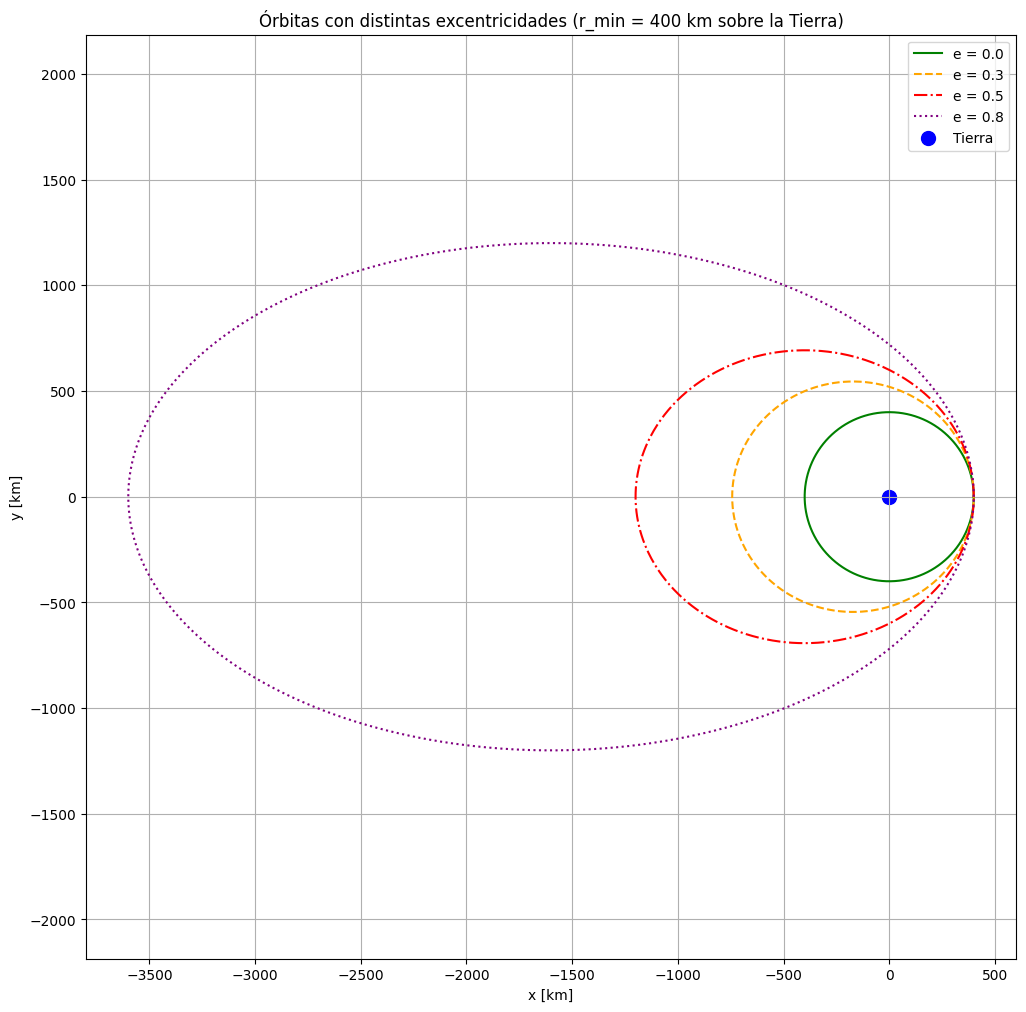

In [52]:
# Excentricidades a graficar
eccentricities = [0.0, 0.3, 0.5, 0.8]
linestyles = ['-', '--', '-.', ':']
colors = ['green', 'orange', 'red', 'purple']

theta = np.linspace(0, 2 * np.pi, 1000)

plt.figure(figsize=(12, 12))

for e, ls, color in zip(eccentricities, linestyles, colors):
    p = r_min * (1 + e)
    r = p / (1 + e * np.cos(theta))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    label = f'e = {e}'
    plt.plot(x / 1e3, y / 1e3, ls, label=label, color=color)

# Tierra en el centro
plt.scatter([0], [0], color='blue', s=100,label='Tierra')

plt.axis('equal')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('Órbitas con distintas excentricidades (r_min = 400 km sobre la Tierra)')
plt.grid(True)
plt.legend()
plt.show()

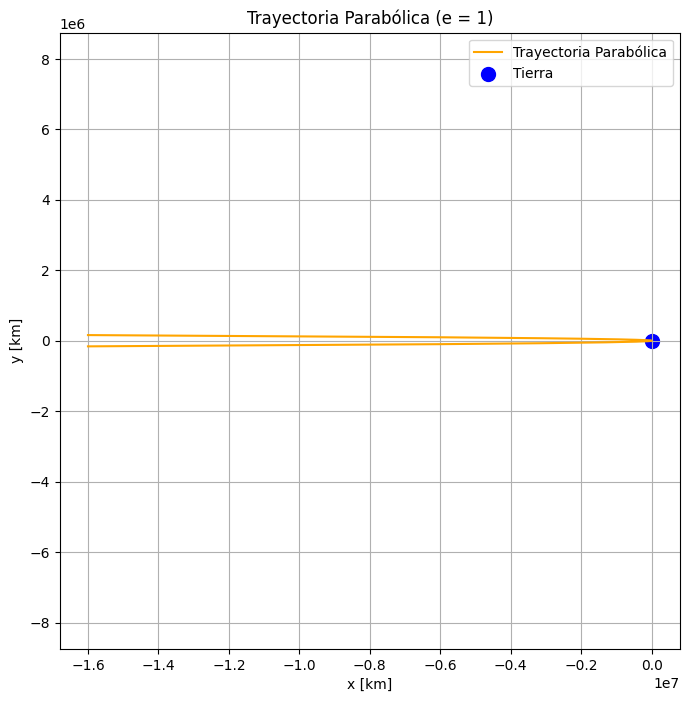

In [59]:
# Parábola: e = 1
e = 1.0
p = 2 * r_min

theta = np.linspace(-np.pi + 0.01, np.pi - 0.01, 1000)  # evitar división por 0

r = p / (1 + e * np.cos(theta))
x = r * np.cos(theta)
y = r * np.sin(theta)

# Graficar
plt.figure(figsize=(8, 8))
plt.plot(x / 1e3, y / 1e3, label='Trayectoria Parabólica', color='orange')
plt.scatter([0], [0], color='blue', s=100, label='Tierra')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.grid(True)
plt.title('Trayectoria Parabólica (e = 1)')
plt.legend()
plt.show()


--- Parámetros de la Maniobra de Hohmann Ideal ---
Radio órbita inicial: 6571.00 km
Radio órbita objetivo: 7071.00 km
Velocidad orbital inicial (circular): 7788.38 m/s
Velocidad en periapsis de transferencia (ideal): 7929.82 m/s
Delta-V 1 requerido (ideal): 141.44 m/s
Velocidad en apoapsis de transferencia (ideal): 7369.09 m/s
Velocidad orbital final (circular): 7507.97 m/s
Delta-V 2 requerido (ideal): 138.87 m/s

--- Duraciones de Impulso Calculadas (basado en Delta-V ideal) ---
Duración calculada para Impulso 1: 5.00 s
Duración calculada para Impulso 2: 64.73 s
Tiempo de coasting calculado (medio período elíptico ideal): 2803.23 s

--- Inicio de la Simulación por Fases ---
Fin Fase 1 (pre-impulso): Altitud=200.00 km, V_rad=-0.00 m/s, V_tan=7788.38 m/s, m=1000.00 kg
Fin Fase 2 (1er impulso): Altitud=200.00 km, V_rad=0.21 m/s, V_tan=7824.46 m/s, m=996.67 kg
Fin Fase 3 (coasting en Apogeo Teórico): Altitud=322.62 km, V_rad=-9.70 m/s, V_tan=7681.12 m/s, m=996.67 kg
Fin Fase 4 (2do impul

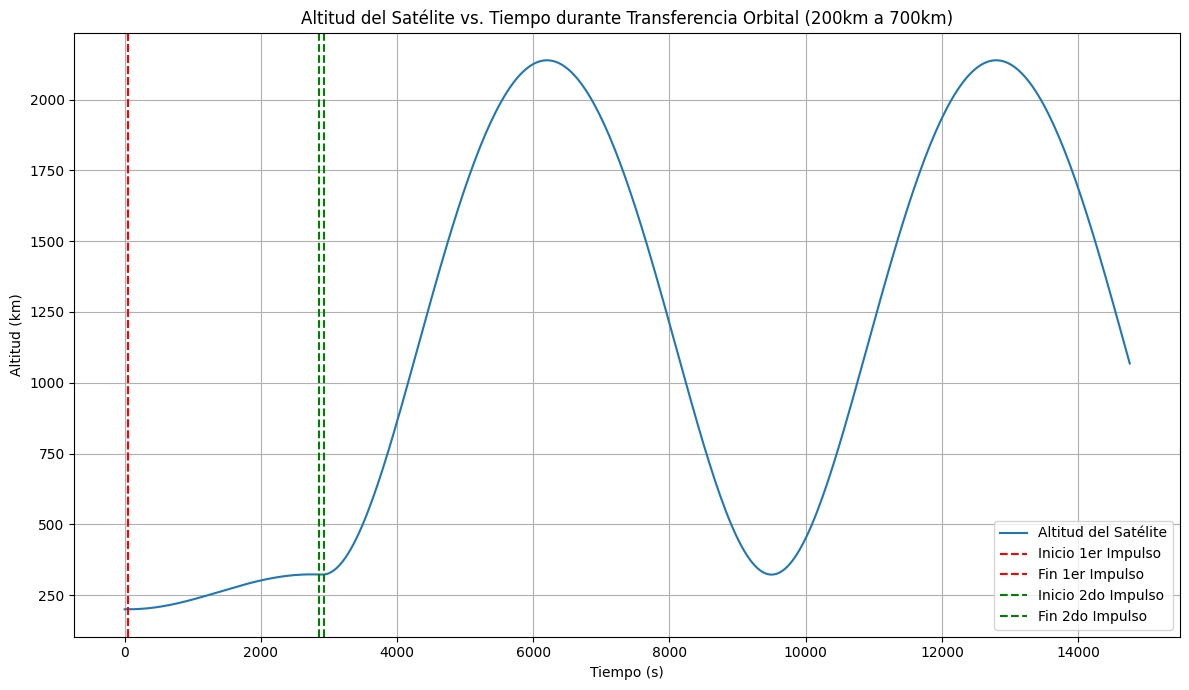


--- Resumen de la Maniobra Final ---
Altitud inicial: 200.00 km
Altitud objetivo: 700.00 km
Altitud final simulada (al final de la simulación): 1068.05 km
Masa inicial del satélite: 1000.00 kg
Masa final del satélite (al final de la simulación): 953.51 kg


In [85]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Definir la función de las EDOs ---
def system_of_equations(state, t, G, M, Ve, current_T_val, m_final_propellant):
    r, dr_dt, theta, dtheta_dt, m = state

    if r < 1.0:
        r = 1.0
        dr_dt = 0.0
        dtheta_dt = 0.0
        dm_dt = 0.0
        return [dr_dt, 0.0, dtheta_dt, 0.0, dm_dt]

    dm_dt = 0.0
    T_effective = current_T_val

    if T_effective > 0 and m > m_final_propellant:
        dm_dt = -T_effective / Ve
    elif m <= m_final_propellant:
        dm_dt = 0.0
        T_effective = 0.0

    d2r_dt2 = - (dm_dt / m) * dr_dt + r * (dtheta_dt**2) - (G * M / r**2)

    denom_d2theta = m * r**2
    if abs(denom_d2theta) < 1e-10:
        d2theta_dt2 = 0.0
    else:
        d2theta_dt2 = (r * T_effective - dm_dt * r**2 * dtheta_dt - 2 * m * r * dr_dt * dtheta_dt) / denom_d2theta

    return [dr_dt, d2r_dt2, dtheta_dt, d2theta_dt2, dm_dt]

# --- 2. Definir Parámetros Físicos ---
G = 6.67430e-11
M = 5.972e24
R_earth = 6.371e6

m_initial_full = 1000.0
m_dry = 900.0

Ve = 3000.0
thrust_magnitude = 2000.0 # Empuje aumentado

# --- 3. Definir Condiciones Iniciales y Objetivos ---
altitude_initial = 200e3 # 200 km
r_initial = R_earth + altitude_initial
v_orbital_initial = np.sqrt(G * M / r_initial)
theta_initial = 0.0
dr_dt_initial = 0.0
dtheta_dt_initial = v_orbital_initial / r_initial

initial_state = [r_initial, dr_dt_initial, theta_initial, dtheta_dt_initial, m_initial_full]

altitude_target = 700e3 # 700 km
r_target = R_earth + altitude_target
v_orbital_target = np.sqrt(G * M / r_target)

# --- Cálculo de los Delta-V y duraciones de los impulsos para Hohmann ---
a_trans = (r_initial + r_target) / 2

v_periapsis_trans = np.sqrt(G * M * (2/r_initial - 1/a_trans))
v_apoapsis_trans = np.sqrt(G * M * (2/r_target - 1/a_trans))

delta_v1_req = v_periapsis_trans - v_orbital_initial
delta_v2_req = v_orbital_target - v_apoapsis_trans

print(f"\n--- Parámetros de la Maniobra de Hohmann Ideal ---")
print(f"Radio órbita inicial: {r_initial/1000:.2f} km")
print(f"Radio órbita objetivo: {r_target/1000:.2f} km")
print(f"Velocidad orbital inicial (circular): {v_orbital_initial:.2f} m/s")
print(f"Velocidad en periapsis de transferencia (ideal): {v_periapsis_trans:.2f} m/s")
print(f"Delta-V 1 requerido (ideal): {delta_v1_req:.2f} m/s")
print(f"Velocidad en apoapsis de transferencia (ideal): {v_apoapsis_trans:.2f} m/s")
print(f"Velocidad orbital final (circular): {v_orbital_target:.2f} m/s")
print(f"Delta-V 2 requerido (ideal): {delta_v2_req:.2f} m/s")

mass_flow_rate = thrust_magnitude / Ve

duration_impulse1 = 5# (m_initial_full * (1 - np.exp(-delta_v1_req / Ve))) / mass_flow_rate
m_expected_after_impulse1_theory = m_initial_full * np.exp(-delta_v1_req / Ve)

duration_impulse2 = (m_expected_after_impulse1_theory * (1 - np.exp(-delta_v2_req / Ve))) / mass_flow_rate
m_final_propellant = m_dry # Masa seca del satélite

print(f"\n--- Duraciones de Impulso Calculadas (basado en Delta-V ideal) ---")
print(f"Duración calculada para Impulso 1: {duration_impulse1:.2f} s")
print(f"Duración calculada para Impulso 2: {duration_impulse2:.2f} s")

duration_coast1 = np.pi * np.sqrt(a_trans**3 / (G * M))
print(f"Tiempo de coasting calculado (medio período elíptico ideal): {duration_coast1:.2f} s")

total_propellant_needed = (duration_impulse1 + duration_impulse2) * mass_flow_rate
if total_propellant_needed > m_initial_full - m_dry:
    print(f"\n¡ADVERTENCIA CRÍTICA! Se necesita más propelente ({total_propellant_needed:.2f} kg) del disponible ({m_initial_full - m_dry:.2f} kg).")
    print("La maniobra podría no completarse según la teoría de Hohmann ideal debido a la falta de combustible.")

# --- 4. Definir Rangos de Tiempo para la Simulación por Fases ---
t_phase1_pre = np.linspace(0, 50, 100)
t_start_impulse1 = t_phase1_pre[-1]
t_phase2_impulse1 = np.linspace(t_start_impulse1, t_start_impulse1 + duration_impulse1, 500)
t_start_coast1 = t_phase2_impulse1[-1]
t_phase3_coast = np.linspace(t_start_coast1, t_start_coast1 + duration_coast1, 1000)
t_start_impulse2 = t_phase3_coast[-1]
t_phase4_impulse2 = np.linspace(t_start_impulse2, t_start_impulse2 + duration_impulse2, 500)
t_start_post = t_phase4_impulse2[-1]
duration_coast_final_display = 2.0 * 2 * np.pi * np.sqrt(r_target**3 / (G*M)) # Dos periodos orbitales finales
t_phase5_post = np.linspace(t_start_post, t_start_post + duration_coast_final_display, 300)

t_total = np.concatenate((t_phase1_pre, t_phase2_impulse1, t_phase3_coast, t_phase4_impulse2, t_phase5_post))

# --- 5. Integrar las Ecuaciones por Fases ---
results = []
current_state = initial_state

print(f"\n--- Inicio de la Simulación por Fases ---")

# Fase 1: Antes del primer impulso (sin empuje)
sol1 = odeint(system_of_equations, current_state, t_phase1_pre,
              args=(G, M, Ve, 0.0, m_dry), rtol=1e-11, atol=1e-11) # AÚN MAYOR PRECISIÓN
results.append(sol1)
current_state = sol1[-1, :]
print(f"Fin Fase 1 (pre-impulso): Altitud={current_state[0]/1000 - R_earth/1000:.2f} km, V_rad={current_state[1]:.2f} m/s, V_tan={current_state[0]*current_state[3]:.2f} m/s, m={current_state[4]:.2f} kg")

# Fase 2: Primer Impulso (Empuje ON)
sol2 = odeint(system_of_equations, current_state, t_phase2_impulse1,
              args=(G, M, Ve, thrust_magnitude, m_dry), rtol=1e-11, atol=1e-11)
results.append(sol2)
current_state = sol2[-1, :]
print(f"Fin Fase 2 (1er impulso): Altitud={current_state[0]/1000 - R_earth/1000:.2f} km, V_rad={current_state[1]:.2f} m/s, V_tan={current_state[0]*current_state[3]:.2f} m/s, m={current_state[4]:.2f} kg")

# Fase 3: Fase de Transferencia (sin empuje)
sol3 = odeint(system_of_equations, current_state, t_phase3_coast,
              args=(G, M, Ve, 0.0, m_dry), rtol=1e-11, atol=1e-11)
results.append(sol3)
current_state = sol3[-1, :]
print(f"Fin Fase 3 (coasting en Apogeo Teórico): Altitud={current_state[0]/1000 - R_earth/1000:.2f} km, V_rad={current_state[1]:.2f} m/s, V_tan={current_state[0]*current_state[3]:.2f} m/s, m={current_state[4]:.2f} kg")


# Fase 4: Segundo Impulso (Empuje ON)
sol4 = odeint(system_of_equations, current_state, t_phase4_impulse2,
              args=(G, M, Ve, thrust_magnitude, m_dry), rtol=1e-11, atol=1e-11)
results.append(sol4)
current_state = sol4[-1, :]
print(f"Fin Fase 4 (2do impulso): Altitud={current_state[0]/1000 - R_earth/1000:.2f} km, V_rad={current_state[1]:.2f} m/s, V_tan={current_state[0]*current_state[3]:.2f} m/s, m={current_state[4]:.2f} kg")


# Fase 5: Después del segundo Impulso (sin empuje)
sol5 = odeint(system_of_equations, current_state, t_phase5_post,
              args=(G, M, Ve, 0.0, m_dry), rtol=1e-11, atol=1e-11)
results.append(sol5)
current_state = sol5[-1, :]
print(f"Fin Fase 5 (post-impulso): Altitud={current_state[0]/1000 - R_earth/1000:.2f} km, V_rad={current_state[1]:.2f} m/s, V_tan={current_state[0]*current_state[3]:.2f} m/s, m={current_state[4]:.2f} kg")

solution_full = np.concatenate(results)
r_sol = solution_full[:, 0]
r_sol[r_sol < R_earth] = R_earth
altitude_sol = (r_sol - R_earth) / 1000

# --- 6. Visualizar los Resultados ---
plt.figure(figsize=(12, 7))
plt.plot(t_total, altitude_sol, label='Altitud del Satélite')
plt.axvline(x=t_phase2_impulse1[0], color='r', linestyle='--', label='Inicio 1er Impulso')
plt.axvline(x=t_phase2_impulse1[-1], color='r', linestyle='--', label='Fin 1er Impulso')
plt.axvline(x=t_phase4_impulse2[0], color='g', linestyle='--', label='Inicio 2do Impulso')
plt.axvline(x=t_phase4_impulse2[-1], color='g', linestyle='--', label='Fin 2do Impulso')

plt.title('Altitud del Satélite vs. Tiempo durante Transferencia Orbital (200km a 700km)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Altitud (km)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n--- Resumen de la Maniobra Final ---")
print(f"Altitud inicial: {altitude_initial/1000:.2f} km")
print(f"Altitud objetivo: {altitude_target/1000:.2f} km")
print(f"Altitud final simulada (al final de la simulación): {altitude_sol[-1]:.2f} km")
print(f"Masa inicial del satélite: {m_initial_full:.2f} kg")
print(f"Masa final del satélite (al final de la simulación): {solution_full[-1, 4]:.2f} kg")

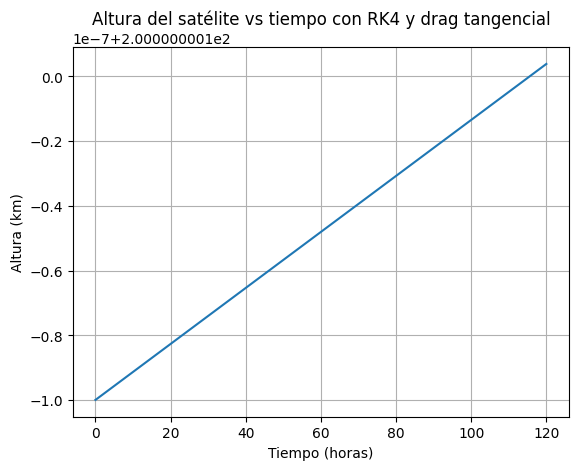

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.67430e-11
M = 5.972e24
R_earth = 6371e3
h0 = 200e3
r0 = R_earth + h0
m = 1000
rho = 1e-11
Cd = 2.2
A = 4.0

# Paso y tiempo total
h = 10  # s
t_max = 120 * 3600  # 1 día
n_steps = int(t_max / h)

# Inicialización
theta = 0
theta_dot = np.sqrt(G * M / r0**3)

theta_list = [theta]
theta_dot_list = [theta_dot]
r_list = [r0]
t_list = [0]

# Funciones del sistema
def f1(theta, theta_dot):
    return theta_dot

def f2(theta, theta_dot):
    return - (0.5 * rho * Cd * A * theta_dot**2) / m

# Runge-Kutta 4
for i in range(n_steps):
    t = h * i

    k1 = h * f1(theta, theta_dot)
    l1 = h * f2(theta, theta_dot)

    k2 = h * f1(theta + k1/2, theta_dot + l1/2)
    l2 = h * f2(theta + k1/2, theta_dot + l1/2)

    k3 = h * f1(theta + k2/2, theta_dot + l2/2)
    l3 = h * f2(theta + k2/2, theta_dot + l2/2)

    k4 = h * f1(theta + k3, theta_dot + l3)
    l4 = h * f2(theta + k3, theta_dot + l3)

    theta += (k1 + 2*k2 + 2*k3 + k4) / 6
    theta_dot += (l1 + 2*l2 + 2*l3 + l4) / 6

    # r actualizado por balance radial
    r = (G * M / theta_dot**2)**(1/3)

    # Guardar
    theta_list.append(theta)
    theta_dot_list.append(theta_dot)
    r_list.append(r)
    t_list.append(t + h)

# Graficar altura
h_list = np.array(r_list) - R_earth
plt.plot(np.array(t_list) / 3600, h_list / 1000)
plt.xlabel("Tiempo (horas)")
plt.ylabel("Altura (km)")
plt.title("Altura del satélite vs tiempo con RK4 y drag tangencial")
plt.grid()
plt.show()


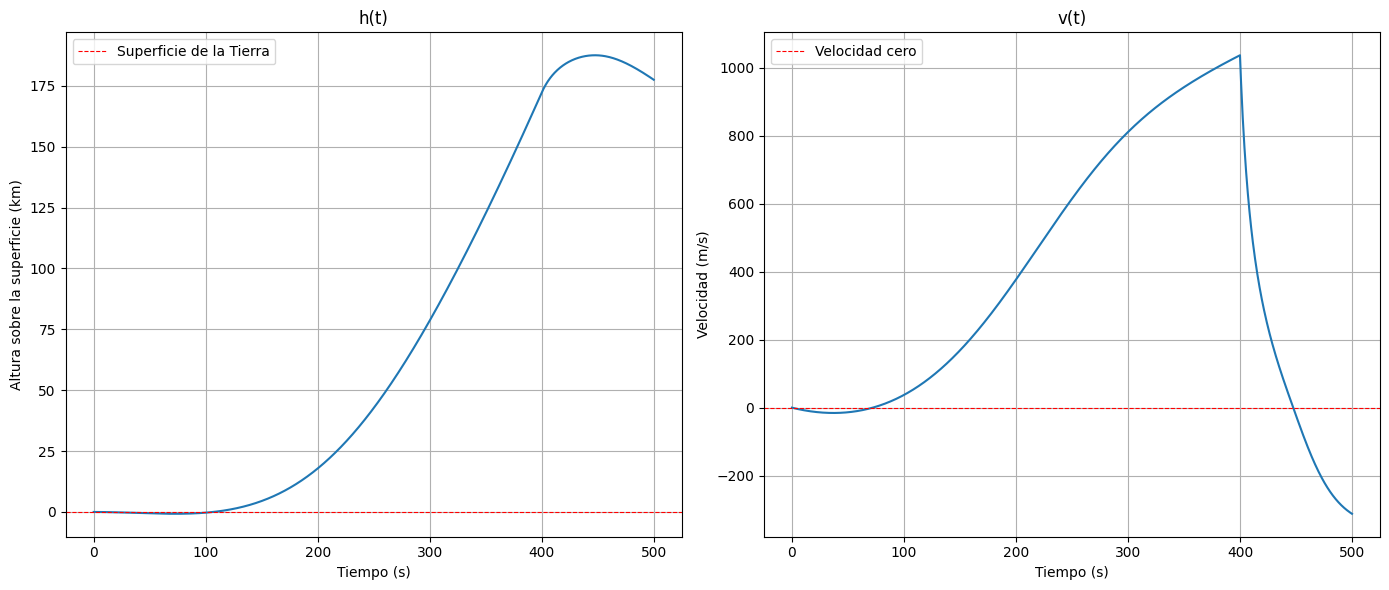

Masa inicial total (M0): 1000.00 toneladas
Masa del propelente inicial: 900.00 toneladas
Masa estructural (cohete vacío): 100.00 toneladas
Tasa de quema de propelente (dm_dt): -2250.00 kg/s
Tiempo estimado de quema de propelente: 400.00 s

Resultados de la simulación:
Tiempo total de simulación: 500.00 s
Altura máxima alcanzada: 187.57 km
Velocidad máxima alcanzada: 1036.80 m/s
Tiempo de velocidad máxima: 400.00 s
Altura en velocidad máxima: 172.24 km
Tiempo de fin de quema de propelente: 400.00 s


In [144]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

M0 = 1000000        
propelente_ratio = 0.90 

M_propelente_inicial = M0 * propelente_ratio
M_estructura = M0 * (1 - propelente_ratio) 

tiempo_quema_estimado = 400
dm_dt = -M_propelente_inicial / tiempo_quema_estimado

vs = 4000          
CD = 1.2           
rho = 1.225        
A = 10             
mu = 3.986e14      
r0 = 6.371e6       
v0 = 0             

def sistema(t, y):
    r, v = y

    current_mass = M0 + dm_dt * t
    m = max(current_mass, M_estructura)

    thrust = 0
    if current_mass > M_estructura: 
        thrust = -dm_dt * vs 

    drag = 0.5 * CD * rho * A * abs(v) * v
    
    gravity_force = mu * m / r**2 

    dvdt = (thrust - gravity_force - drag) / m
    drdt = v

    return [drdt, dvdt]

t_span = (0, 500) 
y0 = [r0, v0]  

sol = solve_ivp(sistema, t_span, y0, method='RK45', max_step=0.5, rtol=1e-6, atol=1e-9)

# --- Gráficos ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# Para la altura sobre la superficie, restamos el radio inicial (r0)
plt.plot(sol.t, (sol.y[0] - r0) / 1000)
plt.xlabel('Tiempo (s)')
plt.ylabel('Altura sobre la superficie (km)')
plt.title('h(t)')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.8, label='Superficie de la Tierra')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sol.t, sol.y[1])
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.title('v(t)')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.8, label='Velocidad cero')
plt.legend()

plt.tight_layout()
plt.show()

# --- Imprimir algunos resultados finales ---
print(f"Masa inicial total (M0): {M0 / 1000:.2f} toneladas")
print(f"Masa del propelente inicial: {M_propelente_inicial / 1000:.2f} toneladas")
print(f"Masa estructural (cohete vacío): {M_estructura / 1000:.2f} toneladas")
print(f"Tasa de quema de propelente (dm_dt): {dm_dt:.2f} kg/s")
print(f"Tiempo estimado de quema de propelente: {M_propelente_inicial / abs(dm_dt):.2f} s")


print(f"\nResultados de la simulación:")
print(f"Tiempo total de simulación: {sol.t[-1]:.2f} s")
print(f"Altura máxima alcanzada: {(np.max(sol.y[0]) - r0) / 1000:.2f} km")
print(f"Velocidad máxima alcanzada: {np.max(sol.y[1]):.2f} m/s")

# Encontrar el tiempo en que la velocidad es máxima
idx_max_vel = np.argmax(sol.y[1])
print(f"Tiempo de velocidad máxima: {sol.t[idx_max_vel]:.2f} s")
print(f"Altura en velocidad máxima: {(sol.y[0][idx_max_vel] - r0) / 1000:.2f} km")

# El cálculo del tiempo de fin de quema ya es correcto
t_fin_quema = M_propelente_inicial / abs(dm_dt)
print(f"Tiempo de fin de quema de propelente: {t_fin_quema:.2f} s")

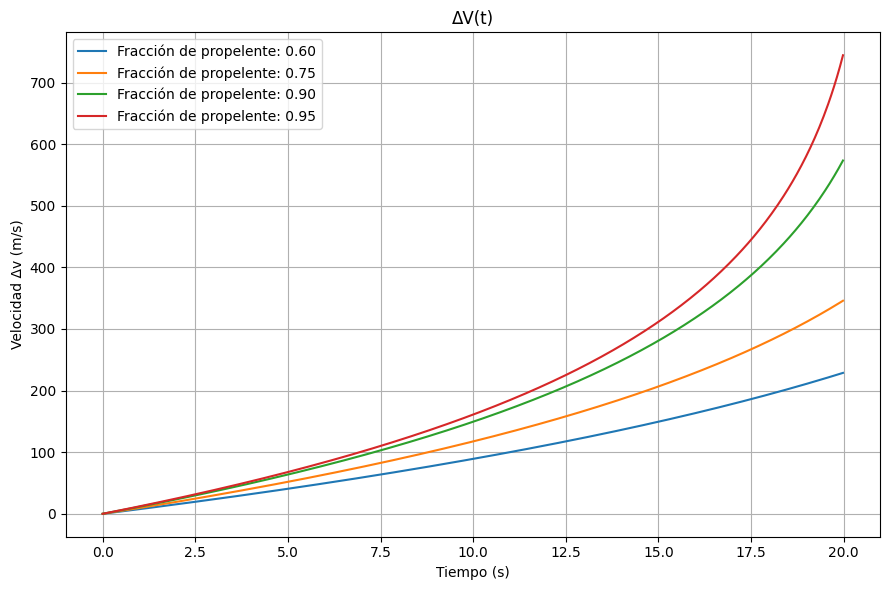

In [147]:
import numpy as np
import matplotlib.pyplot as plt

v_s = 250  # velocidad de eyección (m/s)
M_total = 300  # masa total (kg)
t_b = 20  # tiempo total de combustión (s)

# Vector de tiempo (hasta un poco antes de t_b para evitar log(0))
t = np.linspace(0, t_b*0.999, 500)

# Varias fracciones de propelente para graficar
propellant_fractions = [0.6, 0.75, 0.9, 0.95]

plt.figure(figsize=(9,6))

for P_f in propellant_fractions:
    # Evitar que el argumento del logaritmo sea <=0
    max_t = t_b / P_f
    t_safe = t[t <= max_t * 0.999]  # por si P_f < 1 y supera t_b
    
    delta_v = -v_s * np.log(1 - P_f * t_safe / t_b)
    plt.plot(t_safe, delta_v, label=f'Fracción de propelente: {P_f:.2f}')

plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Δv (m/s)')
plt.title('ΔV(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
